In [25]:
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

allData = pd.read_csv('data.csv', encoding='utf-8-sig')
data = allData[allData['shot_made_flag'].notnull()].reset_index()
print(data.shape)


(25697, 26)


In [21]:
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

# Shown features and corresponding hit rate

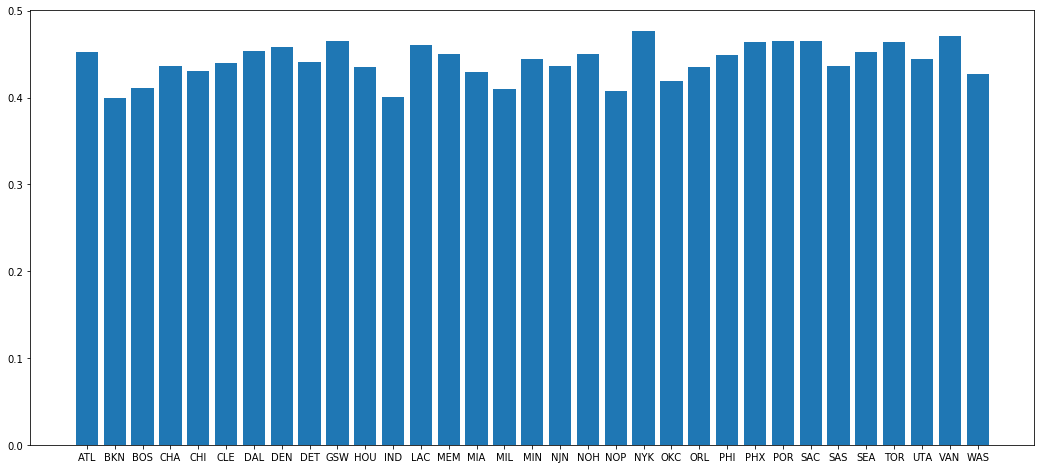

In [22]:
feature_name='opponent'
data[feature_name] = data[feature_name].astype('object')
data_features = data[feature_name];
data_features = pd.unique(data_features)
#print(data_features)
hit_rate = np.zeros((data_features.shape[0],1),dtype=np.float32)
i = 0
for type in data_features:
    sub_type = data.loc[data[feature_name] == type]
    nb_success_hit = sub_type.loc[sub_type['shot_made_flag'] == 1]
    nb_success_hit = nb_success_hit.shape[0]
    nb_fail_hit = sub_type.loc[sub_type['shot_made_flag'] == 0]
    nb_fail_hit = nb_fail_hit.shape[0]
    hit_rate[i] = nb_success_hit/(nb_success_hit+nb_fail_hit)
    i = i+1
hit_rate = hit_rate.reshape(-1)
plt.figure(figsize=(18,8))    
plt.bar(data_features,hit_rate)
plt.show()

# Data pre-processing

In [27]:
X = data[[u'combined_shot_type', u'lat', u'lon', u'loc_x',
       u'loc_y', u'minutes_remaining',
       u'period', u'playoffs', u'season',
       u'seconds_remaining', u'shot_distance']]
X = X.as_matrix()
y = data[[u'shot_made_flag']]

print(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

[['Jump Shot' 34.0443 -118.4268 ..., '2000-01' 22 15]
 ['Jump Shot' 33.9093 -118.3708 ..., '2000-01' 45 16]
 ['Jump Shot' 33.8693 -118.1318 ..., '2000-01' 52 22]
 ..., 
 ['Jump Shot' 33.8783 -118.4038 ..., '1999-00' 28 21]
 ['Jump Shot' 33.7773 -118.2388 ..., '1999-00' 10 26]
 ['Jump Shot' 33.9723 -118.2688 ..., '1999-00' 39 7]]


# Simple Trial

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn import preprocessing

AdaBC = AdaBoostClassifier(n_estimators=20, learning_rate=0.3, random_state=42)
AdaBC.fit(X_train,y_train)
y_predict_proba_AdaBC = AdaBC.predict_proba(X_test)
accuracy_score_AdaBC = accuracy_score(y_test, AdaBC.predict(X_test))
roc_auc_score_AdaBC = roc_auc_score(y_test, y_predict_proba_AdaBC[:,1])

print('The testing accuracy (accuracy_score) is: %f' %accuracy_score_AdaBC)
print('The roc_auc_score is: %f' %roc_auc_score_AdaBC)